In [19]:
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import json
from torchvision import transforms
from nerfstudio.cameras.cameras import Cameras, CameraType
from nerfstudio.utils.eval_utils import eval_setup
from nerfstudio.models.instant_ngp import NGPModel
import time

In [20]:
# Clear cache
torch.cuda.empty_cache()

In [21]:
def image_to_tensor(image_path, device) -> torch.Tensor:
    # Open the image using PIL
    image = Image.open(image_path).convert("RGB")
    
    # Define the transform to convert the image to a PyTorch tensor
    transform = transforms.ToTensor()  # This will convert to a tensor with shape (C, H, W)
    
    # Apply the transform
    tensor = transform(image)  # Shape will be (3, 512, 512)
    
    # Permute the tensor to get shape (512, 512, 3)
    tensor = tensor.permute(1, 2, 0).to(device)
    
    return tensor.detach().requires_grad_(False)

def show_image(tensor):
    plt.figure(figsize=(5, 5))
    plt.imshow(tensor.detach().cpu().numpy())
    plt.axis('off')
    plt.show()

In [22]:
class iNeRFOptimizerBatchedFD:
    def __init__(
        self, 
        nerf_model, 
        target_image,
        initial_pose,
        dataparser_matrix,
        dataparser_scale,
        camera_params,
        loss_fn = nn.MSELoss(),
        lr=0.001,
        num_iterations=1000
    ):
        self.nerf_model = nerf_model
        self.device = nerf_model.device
        self.target_image = target_image.to(self.device)
        
        # Set up dataparser transforms
        self.dataparser_matrix = torch.tensor(dataparser_matrix, dtype=torch.float32, device=self.device)
        self.dataparser_scale = dataparser_scale
        
        # Set up camera parameters
        self.camera_params = camera_params
        
        # Create optimizable pose parameter - just the 3x4 part of the transformation matrix
        self.pose_param = nn.Parameter(
            torch.tensor(initial_pose, dtype=torch.float32, device=self.device)[:3, :4].clone(),
            requires_grad=True
        )
        
        # Optimizer
        self.optimizer = optim.AdamW([self.pose_param], lr=lr)
        self.num_iterations = num_iterations
        self.loss_history = []
        
        # Debug information
        self.timing_stats = {
            'baseline_forward': [],
            'batched_forward': [],
            'gradient_calculation': [],
            'optimization_step': []
        }

        # Loss function substitution
        self.nerf_model.rgb_loss = loss_fn
    
    def optimize_step(self, batch_size=4, debug=True):
        step_start_time = time.time()
        self.optimizer.zero_grad()
        
        # We'll use finite differences to compute gradients
        eps = 1e-4  # Small epsilon for finite differences
        
        # Get current pose parameters
        pose = self.pose_param.detach().clone()
        
        # Time the baseline forward pass
        baseline_start = time.time()
        original_loss, pred_rgb = self.compute_loss_no_grad(pose)
        baseline_time = time.time() - baseline_start
        self.timing_stats['baseline_forward'].append(baseline_time)
        
        if debug:
            print(f"Baseline forward pass took {baseline_time:.4f} seconds")
        
        # Time the batched gradient calculation
        grad_start = time.time()
        
        # Compute gradients using finite differences in batches
        grad = torch.zeros_like(pose)
        
        # Flatten the pose for easier batch processing
        num_params = pose.numel()
        
        # Use coordinate indexing to track which element we're perturbing
        coords = [(i, j) for i in range(pose.shape[0]) for j in range(pose.shape[1])]
        
        # Process in batches
        batched_times = []
        for batch_idx in range(0, num_params, batch_size):
            batch_coords = coords[batch_idx:min(batch_idx+batch_size, num_params)]
            
            batch_start_time = time.time()
            
            # Create a batch of perturbed poses
            batch_poses = []
            for i, j in batch_coords:
                perturbed_pose = pose.clone()
                perturbed_pose[i, j] += eps
                batch_poses.append(perturbed_pose)
            
            # Stack poses into a batch
            batch_poses_tensor = torch.stack(batch_poses)
            
            # Compute losses for all poses in the batch
            batch_losses = self.compute_batch_losses(batch_poses_tensor)
            
            # Calculate gradients
            for idx, (i, j) in enumerate(batch_coords):
                grad[i, j] = (batch_losses[idx] - original_loss) / eps
            
            batch_time = time.time() - batch_start_time
            batched_times.append(batch_time)
            
            if debug and len(batch_coords) > 0:
                avg_time_per_param = batch_time / len(batch_coords)
                processed = batch_idx + len(batch_coords)
                remaining = num_params - processed
                est_time_left = avg_time_per_param * remaining
                
                print(f"  Processed batch {batch_idx//batch_size + 1}/{(num_params+batch_size-1)//batch_size} " + 
                      f"({processed}/{num_params} params, {processed/num_params*100:.1f}%) - " + 
                      f"Batch time: {batch_time:.4f}s - " + 
                      f"Est. time left: {est_time_left:.1f}s")
        
        # Calculate batch statistics
        if debug and batched_times:
            total_batch_time = sum(batched_times)
            self.timing_stats['batched_forward'].append(total_batch_time)
            print(f"Batched forward passes took {total_batch_time:.4f} seconds total")
            print(f"  Speedup vs. individual forward passes: {baseline_time*num_params/total_batch_time:.2f}x")
            if len(batched_times) > 1:
                print(f"  Batch time - Min: {min(batched_times):.4f}s, Max: {max(batched_times):.4f}s, Mean: {np.mean(batched_times):.4f}s")
        
        grad_time = time.time() - grad_start
        self.timing_stats['gradient_calculation'].append(grad_time)
        
        if debug:
            print(f"Gradient calculation took {grad_time:.4f} seconds")
            print(f"Gradient stats - Min: {grad.min().item():.6f}, Max: {grad.max().item():.6f}, Mean: {grad.mean().item():.6f}")
        
        # Manually set gradients
        self.pose_param.grad = grad
        
        # Time the optimization step
        optim_start = time.time()
        self.optimizer.step()
        optim_time = time.time() - optim_start
        self.timing_stats['optimization_step'].append(optim_time)
        
        total_step_time = time.time() - step_start_time
        if debug:
            print(f"Optimization step took {optim_time:.4f} seconds")
            print(f"Total step took {total_step_time:.4f} seconds\n")
        
        return original_loss.item(), pred_rgb
    
    def compute_batch_losses(self, batch_poses):
        """Compute losses for a batch of poses"""
        with torch.no_grad():
            batch_size = batch_poses.shape[0]
            batch_losses = torch.zeros(batch_size, device=self.device)
            
            for i in range(batch_size):
                # Create camera with the given pose
                camera = self.create_camera_from_pose(batch_poses[i])
                
                # Get outputs using the model's built-in method for rendering
                outputs = self.nerf_model.get_outputs_for_camera(camera)
                
                # Compute loss
                pred_rgb, image = self.nerf_model.renderer_rgb.blend_background_for_loss_computation(
                    pred_image=outputs["rgb"],
                    pred_accumulation=outputs["accumulation"],
                    gt_image=self.target_image,
                )
                
                batch_losses[i] = self.nerf_model.rgb_loss(image, pred_rgb)
            
            return batch_losses

    def compute_loss_no_grad(self, pose):
        """Compute loss without requiring gradients"""
        with torch.no_grad():
            # Create camera with the given pose
            camera = self.create_camera_from_pose(pose)
            
            # Get outputs using the model's built-in method for rendering
            outputs = self.nerf_model.get_outputs_for_camera(camera)
            
            # Compute loss
            pred_rgb, image = self.nerf_model.renderer_rgb.blend_background_for_loss_computation(
                pred_image=outputs["rgb"],
                pred_accumulation=outputs["accumulation"],
                gt_image=self.target_image,
            )
            
            loss = self.nerf_model.rgb_loss(image, pred_rgb)
            
        return loss, pred_rgb
    
    def create_camera_from_pose(self, pose):
        """Helper function to create a camera from pose matrix"""
        camera = Cameras(
            camera_to_worlds=pose.unsqueeze(0),
            fx=self.camera_params["fl_x"],
            fy=self.camera_params["fl_y"],
            cx=self.camera_params["cx"],
            cy=self.camera_params["cy"],
            camera_type=CameraType.PERSPECTIVE,
            height=self.camera_params["h"],
            width=self.camera_params["w"],
        )
        return camera

    def run_optimization(self, batch_size=12, visualize_every=50, debug_frequency=10):
        best_loss = float('inf')
        best_pose = None
        best_image = None
        
        print(f"Starting optimization with batch size {batch_size}...")
        overall_start_time = time.time()
        
        for i in range(self.num_iterations):
            iter_start_time = time.time()
            
            # Only output debug info periodically
            debug_this_iter = (i % debug_frequency == 0)
            
            loss, pred_rgb = self.optimize_step(batch_size=batch_size, debug=debug_this_iter)
            self.loss_history.append(loss)
            
            iter_time = time.time() - iter_start_time
            
            if loss < best_loss:
                best_loss = loss
                best_pose = self.pose_param.detach().clone()
                best_image = pred_rgb.detach().clone()
            
            if i % visualize_every == 0 or i == self.num_iterations - 1:
                elapsed_time = time.time() - overall_start_time
                remaining_iters = self.num_iterations - i - 1
                est_time_left = (iter_time * remaining_iters) if i > 0 else 0
                
                print(f"Iteration {i+1}/{self.num_iterations}, Loss: {loss:.8f}")
                print(f"Time for this iteration: {iter_time:.2f}s, Total elapsed: {elapsed_time:.2f}s")
                print(f"Estimated time remaining: {est_time_left:.2f}s ({est_time_left/60:.2f}m)")
                
                if visualize_every > 0:
                    self.visualize_progress(i, loss, pred_rgb)
        
        total_time = time.time() - overall_start_time
        print(f"Optimization completed in {total_time:.2f} seconds ({total_time/60:.2f} minutes)")
        print(f"Best loss: {best_loss:.8f}")
        
        return best_pose, best_image, best_loss, self.loss_history
    
    def visualize_progress(self, iteration, loss, pred_rgb):
        """Visualize the current progress"""
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.imshow(self.target_image.detach().cpu().numpy())
        plt.title("Target Image")
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(pred_rgb.detach().cpu().numpy())
        plt.title(f"Current Render (Loss: {loss:.8f})")
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.plot(self.loss_history)
        plt.title("Loss History")
        plt.xlabel("Iteration")
        plt.ylabel("Loss")
        
        plt.tight_layout()
        plt.show()



In [23]:
    # def plot_timing_stats(self):
    #     """Plot timing statistics"""
    #     plt.figure(figsize=(12, 6))
        
    #     # Convert lists to arrays for easier manipulation
    #     baseline_times = np.array(self.timing_stats['baseline_forward'])
    #     batched_times = np.array(self.timing_stats['batched_forward'])
    #     grad_times = np.array(self.timing_stats['gradient_calculation'])
    #     optim_times = np.array(self.timing_stats['optimization_step'])
        
    #     # Find the minimum length of all timing arrays
    #     min_length = min(len(baseline_times), len(batched_times), 
    #                     len(grad_times), len(optim_times))
        
    #     # Use only the data points that exist for all metrics
    #     baseline_times = baseline_times[-min_length:]
    #     batched_times = batched_times[-min_length:]
    #     grad_times = grad_times[-min_length:]
    #     optim_times = optim_times[-min_length:]
        
    #     # Create x-axis for plots based on the common length
    #     x = np.arange(min_length)
        
    #     # Plot individual timing components
    #     plt.subplot(1, 2, 1)
    #     plt.plot(x, baseline_times, 'b-', label='Baseline Forward')
    #     plt.plot(x, batched_times, 'c-', label='Batched Forward')
    #     plt.plot(x, grad_times, 'r-', label='Gradient Calculation')
    #     plt.plot(x, optim_times, 'g-', label='Optimizer Step')
    #     plt.xlabel('Iteration')
    #     plt.ylabel('Time (seconds)')
    #     plt.title('Timing Breakdown by Component')
    #     plt.legend()
    #     plt.grid(True, alpha=0.3)
        
    #     # Plot total time per iteration
    #     plt.subplot(1, 2, 2)
    #     total_times = grad_times + optim_times
    #     plt.bar(x, batched_times, label='Forward Passes', color='b', alpha=0.7)
    #     plt.bar(x, optim_times, bottom=batched_times, label='Optimizer Step', color='g', alpha=0.7)
    #     plt.xlabel('Iteration')
    #     plt.ylabel('Time (seconds)')
    #     plt.title('Total Time per Iteration')
    #     plt.legend()
    #     plt.grid(True, alpha=0.3)
        
    #     # Calculate and print timing statistics
    #     print(f"Timing Statistics (last {len(baseline_times)} iterations):")
    #     print(f"  Baseline Forward:      {baseline_times.mean():.4f}s (±{baseline_times.std():.4f}s)")
    #     print(f"  Batched Forward:       {batched_times.mean():.4f}s (±{batched_times.std():.4f}s)")
    #     print(f"  Gradient Calculation:  {grad_times.mean():.4f}s (±{grad_times.std():.4f}s)")
    #     print(f"  Optimization Step:     {optim_times.mean():.4f}s (±{optim_times.std():.4f}s)")
    #     print(f"  Total per Iteration:   {(batched_times+optim_times).mean():.4f}s (±{(batched_times+optim_times).std():.4f}s)")
        
    #     plt.tight_layout()
    #     plt.show()

In [24]:
config_path = Path("/n/home10/dpodolskyi/neural-registration/outputs/0_065_cat5_2/instant-ngp/2024-08-20_140044/config.yml")
_, pipeline, _, _ = eval_setup(config_path=config_path, test_mode="inference")
nerf_model = pipeline.model
nerf_device = nerf_model.device

# Load dataparser transforms
dataparser_transforms_path = Path("/n/home10/dpodolskyi/neural-registration/outputs/0_065_cat5_2/instant-ngp/2024-08-20_140044/dataparser_transforms.json")
with open(dataparser_transforms_path, "r") as f:
    dataparser_transform = json.load(f)

dataparser_matrix = torch.tensor(dataparser_transform["transform"], dtype=torch.float32)
dataparser_matrix = np.vstack((dataparser_matrix, np.array([[0, 0, 0, 1]])))
dataparser_scale = dataparser_transform["scale"]

# Initial camera pose
initial_pose = np.array([
    [-0.16551750084030392, 0.17173068552312126, -0.9711398089695112, -80.73672706466026],
    [-0.9756847655052445, 0.11494663876681419, 0.18661861803471735, 15.51473463480075],
    [0.14367740002017088, 0.9784149640546033, 0.14852933325600515, 12.348141976499424],
    [0, 0, 0, 1],
])

# Apply dataparser transform
final_initial_pose = np.dot(dataparser_matrix, initial_pose)
final_initial_pose[:3, 3] = final_initial_pose[:3, 3] * dataparser_scale

# Camera parameters
camera_params = {
    "camera_angle_x": 0.5235987755982988,
    "camera_angle_y": 0.5235987755982988,
    "fl_x": 955.4050067376327,
    "fl_y": 955.4050067376327,
    "k1": 0, "k2": 0, "k3": 0, "k4": 0, "p1": 0, "p2": 0,
    "is_fisheye": False,
    "cx": 256.0, "cy": 256.0,
    "w": 512, "h": 512,
    "aabb_scale": 32,
}

# Load target image 
target_image_path = "/n/home10/dpodolskyi/neural-registration/data/datasets/0_065_cat5_2.0/images/4.png"
target_image = image_to_tensor(target_image_path, nerf_device)

Loading latest checkpoint from load_dir

✅ Done loading checkpoint from outputs/0_065_cat5_2/instant-ngp/2024-08-20_140044/nerfstudio_models/step-000018000.ckpt

In [38]:
# Different loss functions to compare rgb images
import pytorch_msssim

l1_loss = nn.L1Loss()
l2_loss = nn.MSELoss()

huber_loss = nn.SmoothL1Loss(beta=0.5)

class StructuralSimilarityIndexLoss(nn.Module):
    def __init__(self):
        super(StructuralSimilarityIndexLoss, self).__init__()
    
    def forward(self, x, y):
        # Rearrange dimensions if needed
        if x.dim() == 3:  # [H, W, C]
            # Rearrange to [1, C, H, W]
            x = x.permute(2, 0, 1).unsqueeze(0)
            y = y.permute(2, 0, 1).unsqueeze(0)
        
        return 1 - pytorch_msssim.ssim(x, y)

class MultiScaleSSIMLoss(nn.Module):
    def __init__(self):
        super(MultiScaleSSIMLoss, self).__init__()
    
    def forward(self, x, y):
        # Rearrange dimensions if needed
        if x.dim() == 3:  # [H, W, C]
            # Rearrange to [1, C, H, W]
            x = x.permute(2, 0, 1).unsqueeze(0)
            y = y.permute(2, 0, 1).unsqueeze(0)
        
        return 1 - pytorch_msssim.ms_ssim(x, y)

class SanityCheckLoss(nn.Module):
    def __init__(self):
        super(SanityCheckLoss, self).__init__()
    
    def forward(self, x, y):
        # Return a scalar tensor with value 0
        # Make sure it's on the same device as inputs
        return torch.tensor(0.0, device=x.device, dtype=x.dtype)

# Initialize the loss modules
structural_similarity_index_loss = StructuralSimilarityIndexLoss()
multi_scale_ssim_loss = MultiScaleSSIMLoss()
sanity_check_loss = SanityCheckLoss()

Starting optimization with batch size 12...
Baseline forward pass took 9.0475 seconds


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  Processed batch 1/1 (12/12 params, 100.0%) - Batch time: 11.0777s - Est. time left: 0.0s
Batched forward passes took 11.0777 seconds total
  Speedup vs. individual forward passes: 9.80x
Gradient calculation took 11.0779 seconds
Gradient stats - Min: -0.027418, Max: 0.029802, Mean: 0.001887
Optimization step took 0.0004 seconds
Total step took 20.1264 seconds

Iteration 1/50, Loss: 0.00545216
Time for this iteration: 20.13s, Total elapsed: 20.13s
Estimated time remaining: 0.00s (0.00m)


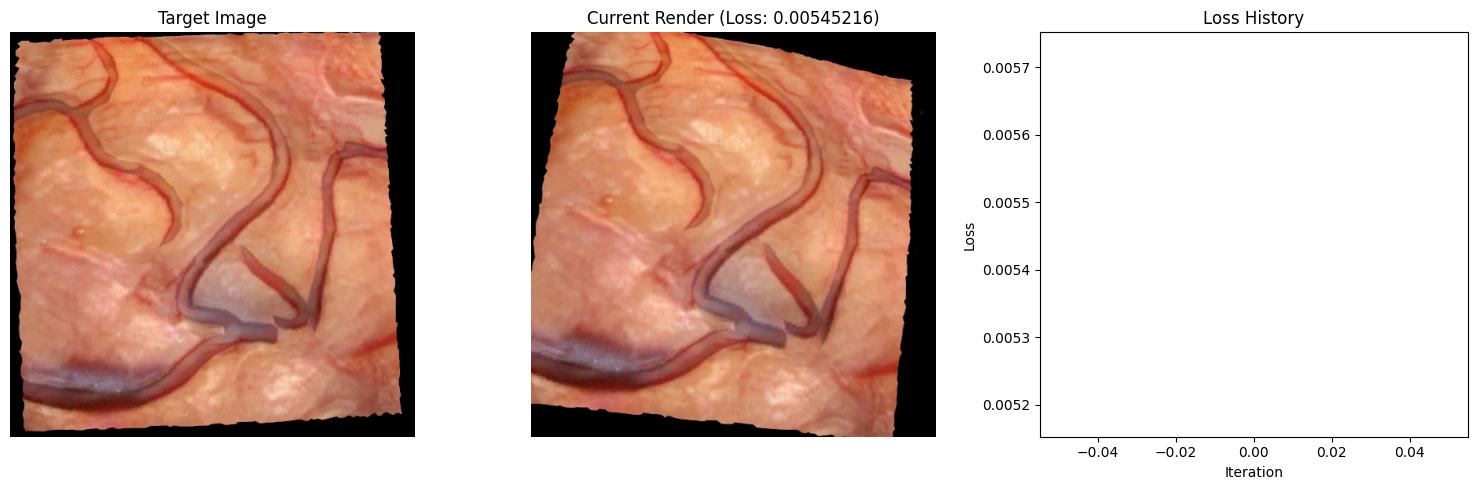

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration 6/50, Loss: 0.00387657
Time for this iteration: 12.12s, Total elapsed: 80.76s
Estimated time remaining: 533.48s (8.89m)


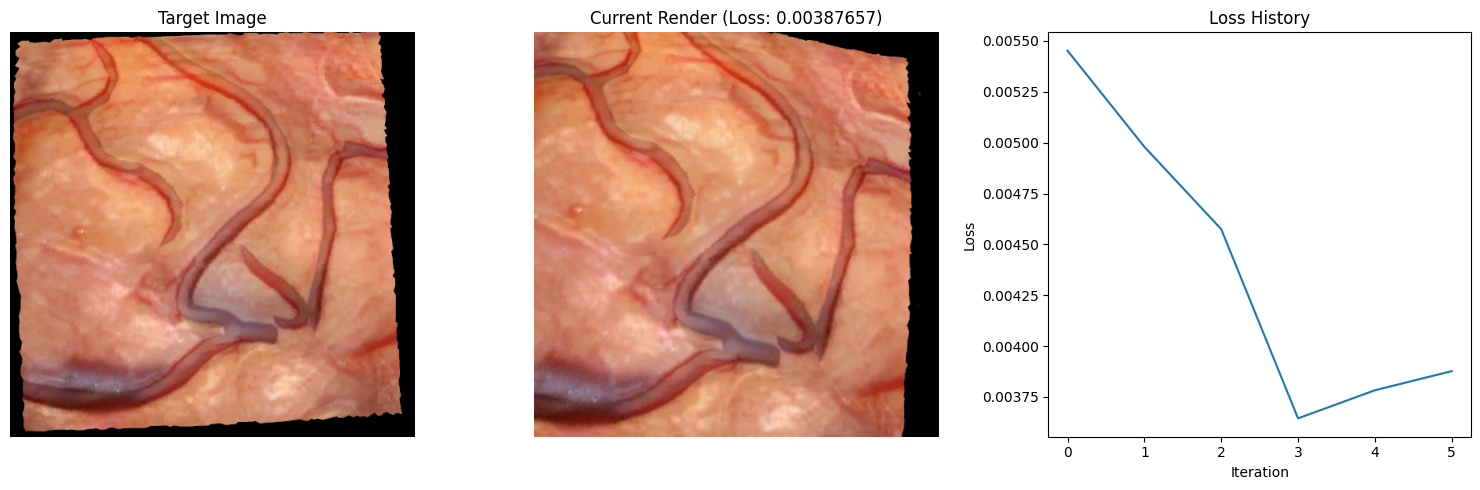

Baseline forward pass took 0.9258 seconds


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


  Processed batch 1/1 (12/12 params, 100.0%) - Batch time: 11.1211s - Est. time left: 0.0s
Batched forward passes took 11.1211 seconds total
  Speedup vs. individual forward passes: 1.00x
Gradient calculation took 11.1214 seconds
Gradient stats - Min: -0.057220, Max: 0.058413, Mean: -0.001440
Optimization step took 0.0003 seconds
Total step took 12.0626 seconds

Iteration 11/50, Loss: 0.00309443
Time for this iteration: 12.06s, Total elapsed: 141.66s
Estimated time remaining: 470.44s (7.84m)


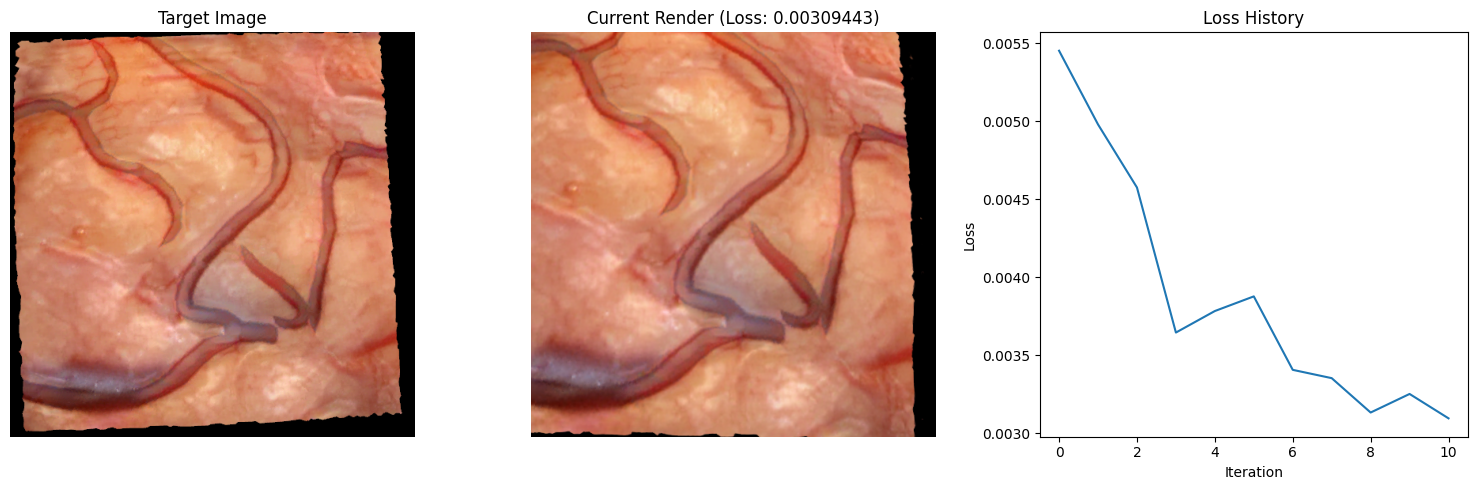

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Iteration 16/50, Loss: 0.00285494
Time for this iteration: 12.04s, Total elapsed: 202.30s
Estimated time remaining: 409.46s (6.82m)


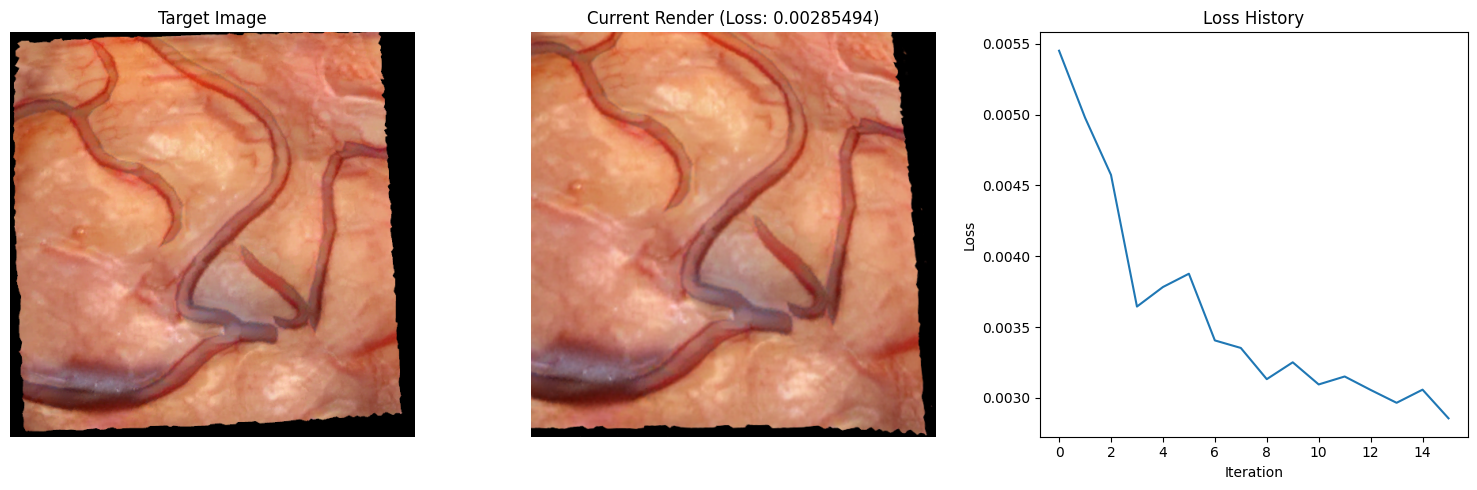

Baseline forward pass took 0.9236 seconds


In [ ]:
inerf_optimizer = iNeRFOptimizerBatchedFD(
    nerf_model=nerf_model,
    target_image=target_image,
    initial_pose=final_initial_pose,
    dataparser_matrix=dataparser_matrix,
    dataparser_scale=dataparser_scale,
    camera_params=camera_params,
    loss_fn=structural_similarity_index_loss,
    lr=0.01,
    num_iterations=50
)
batch_size = 12  # Adjust based on your GPU memory
best_pose, best_image, best_loss, loss_history = inerf_optimizer.run_optimization(batch_size=batch_size, visualize_every=5)